[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ee-ortiz/ISIS-4825_202510_IMAGENES_Y_VISION/blob/main/Laboratorio_08/MISIS4825_Laboratorio08_Taller.ipynb)

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# Laboratorio 08 – Taller: Redes Neuronales Convolucionales con Modelos Fundacionales

## Introducción

En este taller abordaremos el tema de las redes neuronales convolucionales (CNN) y la aplicación de **modelos fundacionales** mediante *transfer learning*. Para ello, utilizaremos el conjunto de datos **drone-bird classification** de Kaggle.

El objetivo es comparar el rendimiento de un modelo CNN entrenado desde cero con el de un modelo fundacional (por ejemplo, VGG16) adaptado a nuestra tarea de **clasificación de Drones y aves**.

## Objetivos

1. **Entrenar un modelo CNN desde cero** utilizando Keras y TensorFlow.
2. **Aplicar transfer learning** con un modelo fundacional, aprovechando características previamente aprendidas en conjuntos de datos masivos.
3. **Comparar** el rendimiento y la eficiencia de ambos enfoques.
4. **Experimentar** con distintos modelos fundacionales y diferentes configuraciones de hiperparámetros.


**Datos:** [drone-bird classification](https://www.kaggle.com/datasets/preetpalsingh25/alzheimers-dataset-4-class-of-images)

## 1. Descarga y Preparación del Dataset de Kaggle

In [1]:
import os
import json

In [2]:
# Instalación de Kaggle
!pip install kaggle --quiet

In [4]:
# Cargar credenciales desde kaggle.json
with open('kaggle.json', 'r') as f:
    kaggle_creds = json.load(f)
os.environ['KAGGLE_USERNAME'] = kaggle_creds['username']
os.environ['KAGGLE_KEY'] = kaggle_creds['key']

# Descarga del dataset
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('imbikramsaha/drone-bird-classification', path='data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/imbikramsaha/drone-bird-classification


## 2. Exploración de Datos

Vamos a inspeccionar la carpeta que contiene las imágenes de drones y aves y crear un DataFrame con la ruta de cada imagen y su etiqueta. Luego, mostraremos cada una de las categorías y un breve conteo de cuántas imágenes hay por categoría.

Total de imágenes: 324

Número de imágenes por categoría:
label
birds     164
drones    160
Name: count, dtype: int64


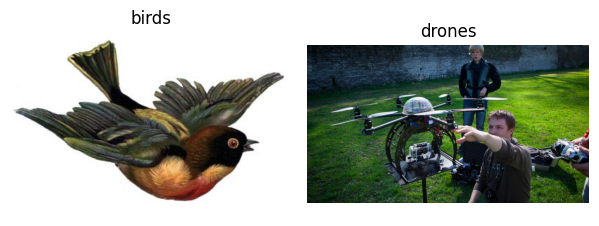

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Directorio base que contiene las carpetas 'train' y 'test'
base_dir = 'data/drone_or_bird'

filepaths = []
labels = []

# Recorrer las carpetas 'train' y 'test'
for label in os.listdir(base_dir):
    label_path = os.path.join(base_dir, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            ext = os.path.splitext(file)[1].lower()
            if ext in ['.png', '.jpg', '.jpeg']:
                filepaths.append(os.path.join(label_path, file))
                labels.append(label)

# Crear DataFrame con las rutas y etiquetas
data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Mostrar conteo total y por categoría
print("Total de imágenes:", len(data_df))
print("\nNúmero de imágenes por categoría:")
print(data_df['label'].value_counts())

# Mostrar una imagen por categoría
categorias = data_df['label'].unique()
num_muestras = len(categorias)

plt.figure(figsize=(15, 10))
for i, categoria in enumerate(categorias[:num_muestras]):
    img_path = data_df[data_df['label'] == categoria].iloc[0]['filepath']
    img = mpimg.imread(img_path)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{categoria}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 3. Preprocesamiento de Datos

Dividimos el dataset completo en tres conjuntos:
- **Entrenamiento (70%)**
- **Validación (20%)**
- **Prueba (10%)**

Esta separación nos permitirá evaluar la capacidad de generalización de nuestros modelos.

In [6]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en 70% entrenamiento y 30% (validación + prueba)
train_df, test_val_df = train_test_split(
    data_df, test_size=0.3, random_state=42, stratify=data_df['label']
)

# A partir del 30% restante, dividir en 2/3 para validación y 1/3 para prueba (~20% y ~10% del total, respectivamente)
val_df, test_df = train_test_split(
    test_val_df, test_size=(1/3), random_state=42, stratify=test_val_df['label']
)

print("Entrenamiento:", len(train_df))
print("Validación:", len(val_df))
print("Prueba:", len(test_df))


Entrenamiento: 226
Validación: 65
Prueba: 33


## 4. Generadores de Imágenes

Utilizaremos la clase `ImageDataGenerator` de Keras para:
- Reescalar los valores de píxel al rango [0, 1].
- Aplicar data augmentation (rotación, volteo horizontal) en el conjunto de entrenamiento.
- Mantener intactos los conjuntos de validación y prueba (solo reescalado).

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True
)

test_val_datagen = ImageDataGenerator(
    rescale=1./255
)

img_size = (128, 128)  # Compatible con la mayoría de modelos fundacionales
batch_size = 32

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=img_size, batch_size=batch_size,
    class_mode='categorical'
)

val_gen = test_val_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

test_gen = test_val_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

# Diccionario con nombre de clase -> índice
labels_map = train_gen.class_indices

# Invertimos el diccionario para tener índice -> nombre de clase
idx_to_class = {v: k for k, v in labels_map.items()}

print("\nCategorías reconocidas:")
for idx in sorted(idx_to_class):
    print(f"  Clase {idx}: '{idx_to_class[idx]}'")

num_classes = len(labels_map)
print("Número de clases:", num_classes)

Found 226 validated image filenames belonging to 2 classes.
Found 65 validated image filenames belonging to 2 classes.
Found 33 validated image filenames belonging to 2 classes.

Categorías reconocidas:
  Clase 0: 'birds'
  Clase 1: 'drones'
Número de clases: 2


## 5. Construcción del Modelo de Red Convolucional

En esta sección, definiremos una CNN desde cero (modelo *scratch*) para la clasificación de fracturas. Este modelo tendrá varias capas convolucionales y capas de pooling, seguido de capas densas para la clasificación.


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_scratch = Sequential([
    # Primer bloque convolucional
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # Segundo bloque
    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # Tercer bloque
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # Aplanamiento y capas densas
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model_scratch.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,538,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,677,986 (21.66 MB)

 Trainable params: 5,677,986 (21.66 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Definición de Callbacks

Utilizamos *ModelCheckpoint* para guardar la mejor versión del modelo, *EarlyStopping* para detener el entrenamiento cuando la métrica de validación deje de mejorar y *ReduceLROnPlateau* para ajustar dinámicamente la tasa de aprendizaje.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model_scratch.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_scratch = [
    ModelCheckpoint('best_model_scratch.keras', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')
]

## 7. Entrenamiento del Modelo

Entrenamos la red desde cero con los parámetros definidos anteriormente.  

In [ ]:
import tensorflow as tf

epochs_scratch = 15
with tf.device('/device:GPU:0'):
    history_scratch = model_scratch.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs_scratch,
        callbacks=callbacks_scratch
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4273 - loss: 0.8814 - val_accuracy: 0.5077 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 499ms/step - accuracy: 0.5336 - loss: 0.6966 - val_accuracy: 0.5077 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 547ms/step - accuracy: 0.5036 - loss: 0.6912 - val_accuracy: 0.5231 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 607ms/step - accuracy: 0.5876 - loss: 0.6914 - val_accuracy: 0.5077 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - accuracy: 0.5336 - loss: 0.6911 - val_accuracy: 0.5231 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 489ms/step - accuracy: 0.5018 - loss: 0.6907 - val_accuracy: 0.5231 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 626ms/step - accuracy: 0.5633 - loss: 0.6855 - val_accuracy: 0.

## 8. Evaluación del Modelo

Visualizaremos las curvas de entrenamiento (precisión y pérdida) y cargaremos la mejor versión del modelo para evaluar en el conjunto de prueba.

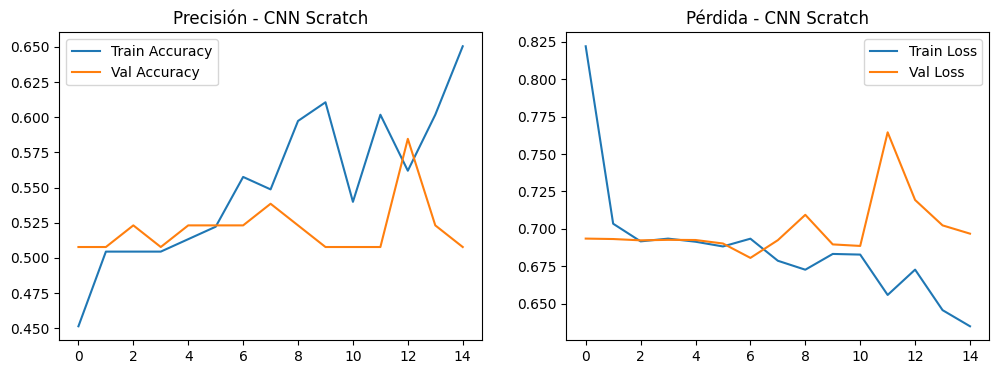

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 700ms/step


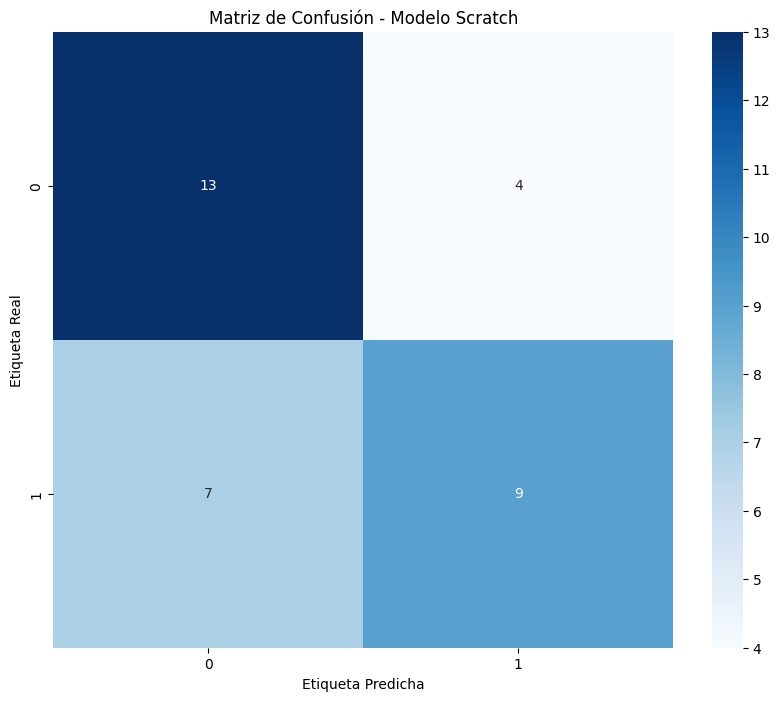

Reporte de Clasificación - Modelo Scratch

              precision    recall  f1-score   support

       birds       0.65      0.76      0.70        17
      drones       0.69      0.56      0.62        16

    accuracy                           0.67        33
   macro avg       0.67      0.66      0.66        33
weighted avg       0.67      0.67      0.66        33



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Graficar la historia de entrenamiento
acc = history_scratch.history['accuracy']
val_acc = history_scratch.history['val_accuracy']
loss = history_scratch.history['loss']
val_loss = history_scratch.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Precisión - CNN Scratch')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Pérdida - CNN Scratch')
plt.show()

# Cargar el mejor modelo y evaluar
best_scratch_model = load_model('best_model_scratch.keras')
test_gen.reset()
preds_scratch = best_scratch_model.predict(test_gen, verbose=1)
y_pred_scratch = np.argmax(preds_scratch, axis=1)
y_true = test_gen.classes

cm_scratch = confusion_matrix(y_true, y_pred_scratch)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_scratch, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Modelo Scratch')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

print("Reporte de Clasificación - Modelo Scratch")
print()
print(classification_report(y_true, y_pred_scratch, target_names=labels_map, zero_division=0))

## 9. Transfer Learning con Modelos Fundacionales

En esta sección se aprovechará el poder de un modelo pre-entrenado, en concreto **VGG16**, para aplicar *transfer learning* en nuestra tarea de clasificación de imágenes. Utilizar un modelo como VGG16 permite:
  
- **Reducción en el tiempo de entrenamiento:** El modelo base ya ha sido entrenado en un conjunto masivo (ImageNet), lo que significa que las capas iniciales han aprendido a extraer características generales muy útiles.
- **Mejor rendimiento en datasets limitados:** Al reutilizar las representaciones aprendidas, se pueden obtener resultados competitivos incluso cuando el conjunto de datos de destino es relativamente pequeño.
  
### Sobre VGG16

VGG16 fue desarrollado por Simonyan y Zisserman en su artículo *"Very Deep Convolutional Networks for Large-Scale Image Recognition"* ([ver paper](https://arxiv.org/abs/1409.1556)). Algunas de sus características destacadas son:

- **Filtros uniformes:** Emplea filtros uniformes de 3x3 a lo largo de toda la arquitectura, lo que facilita la extracción sistemática de patrones jerárquicos a distintos niveles de abstracción.
- **Estructura profunda:** Consta de 16 capas con pesos (13 capas convolucionales y 3 capas densas), lo que permite una representación rica y detallada de las imágenes.
- **Simplicidad en el diseño:** A pesar de su profundidad, utiliza únicamente capas convolucionales con pequeños filtros y capas de pooling, lo que resulta en una arquitectura elegante y uniforme.

A continuación, se muestra un diagrama ilustrativo de la arquitectura VGG16:

![Arquitectura VGG16](https://miro.medium.com/v2/resize:fit:720/1*lXCy8RLUOtAwoS2H4ortZA.png)


### Implementación con VGG16

El siguiente bloque de código carga VGG16 sin la parte superior (la capa de clasificación final), congela sus capas para evitar su reentrenamiento, y añade una parte superior que se adapta a nuestro problema. Se entrena el modelo y se guardan las mejores versiones según la métrica de validación.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Cargar VGG16 pre-entrenado en ImageNet, sin incluir la parte superior
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelar todas las capas del modelo base para no reentrenarlas
for layer in base_model_vgg.layers:
    layer.trainable = False

# Construir el modelo de transfer learning
model_vgg = Sequential([
    base_model_vgg,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Mostrar la arquitectura del modelo
model_vgg.summary()

# Compilar el modelo
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definir callbacks para guardar el mejor modelo, detener tempranamente y reducir la tasa de aprendizaje
callbacks_vgg = [
    ModelCheckpoint('best_model_vgg.keras', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')
]

# Entrenar el modelo de transfer learning
epochs_vgg = 15
with tf.device('/device:GPU:0'):
    history_vgg = model_vgg.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs_vgg,
        callbacks=callbacks_vgg
    )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6001 - loss: 0.7022 - val_accuracy: 0.6615 - val_loss: 0.6580 - learning_rate: 0.0010
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 651ms/step - accuracy: 0.6446 - loss: 0.6173 - val_accuracy: 0.6462 - val_loss: 0.5746 - learning_rate: 0.0010
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 568ms/step - accuracy: 0.6638 - loss: 0.5661 - val_accuracy: 0.7538 - val_loss: 0.4999 - learning_rate: 0.0010
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 539ms/step - accuracy: 0.7827 - loss: 0.4727 - val_accuracy: 0.8000 - val_loss: 0.4467 - learning_rate: 0.0010
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 590ms/step - accuracy: 0.8281 - loss: 0.4097 - val_accuracy: 0.8000 - val_loss: 0.4133 - learning_rate: 0.0010
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 478ms/step - accuracy: 0.8417 - loss: 0.3961 - val_accuracy: 0.8462 - val_loss: 0.3745 - learning_rate: 0.0010
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 542ms/step - accuracy: 0.8562 - loss: 0.3656 - val_accuracy: 0.

### Evaluación del Modelo

Visualizaremos las curvas de entrenamiento y evaluaremos la mejor versión del modelo en el conjunto de prueba.

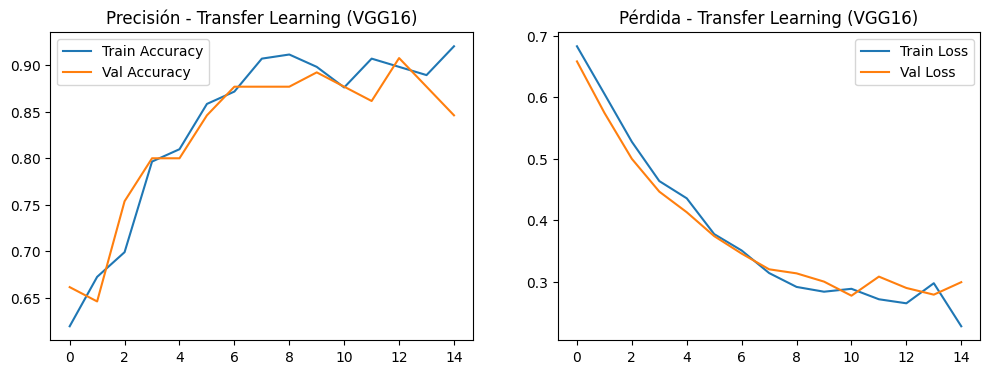

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 761ms/step


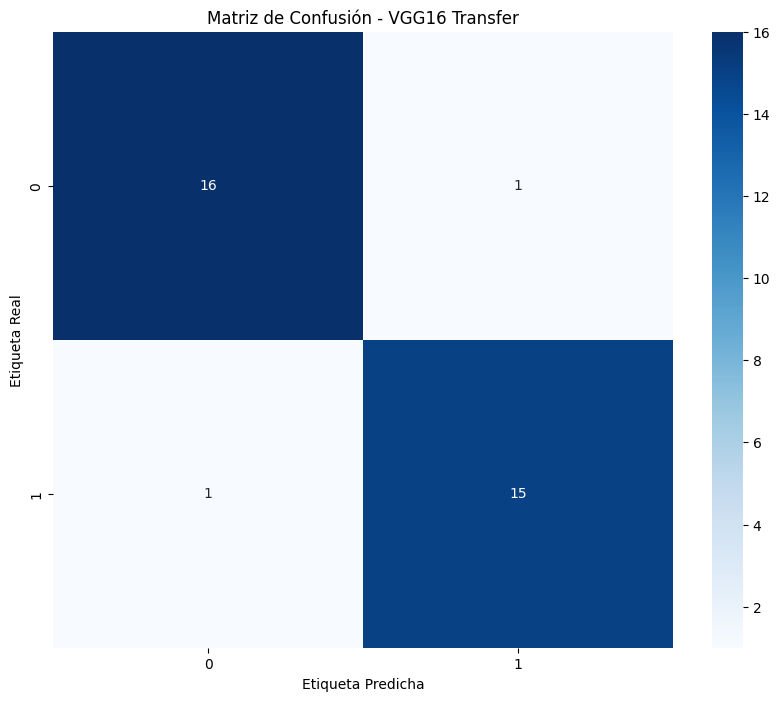

Reporte de Clasificación - Transfer Learning (VGG16)

              precision    recall  f1-score   support

       birds       0.94      0.94      0.94        17
      drones       0.94      0.94      0.94        16

    accuracy                           0.94        33
   macro avg       0.94      0.94      0.94        33
weighted avg       0.94      0.94      0.94        33



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Graficar la historia de entrenamiento
acc_vgg = history_vgg.history['accuracy']
val_acc_vgg = history_vgg.history['val_accuracy']
loss_vgg = history_vgg.history['loss']
val_loss_vgg = history_vgg.history['val_loss']
epochs_range_vgg = range(len(acc_vgg))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_vgg, acc_vgg, label='Train Accuracy')
plt.plot(epochs_range_vgg, val_acc_vgg, label='Val Accuracy')
plt.legend()
plt.title('Precisión - Transfer Learning (VGG16)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_vgg, loss_vgg, label='Train Loss')
plt.plot(epochs_range_vgg, val_loss_vgg, label='Val Loss')
plt.legend()
plt.title('Pérdida - Transfer Learning (VGG16)')
plt.show()

# Cargar el mejor modelo y evaluar
best_vgg_model = load_model('best_model_vgg.keras')
test_gen.reset()
preds_vgg = best_vgg_model.predict(test_gen, verbose=1)
y_pred_vgg = np.argmax(preds_vgg, axis=1)

cm_vgg = confusion_matrix(y_true, y_pred_vgg)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - VGG16 Transfer')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

print("Reporte de Clasificación - Transfer Learning (VGG16)")
print()
print(classification_report(y_true, y_pred_vgg, target_names=labels_map, zero_division=0))

## 10. Conclusiones y Discusión

- **Comparación entre modelo Scratch y el modelo VGG16:**  
  - ¿Cuál obtuvo mejor precisión y cuál converge más rápido?
  - ¿Fue necesario más tiempo para entrenar la red desde cero?
  - ¿Por qué la arquitectura pre-entrenada podría ofrecer ventajas cuando el dataset de destino no es enorme?

- **Experimentación con Otros Modelos Fundacionales:**  
  1. Probar otras arquitecturas, como SqueezeNet, MobileNetV2, ResNet50, InceptionV3 o cualquiera de su elección.
  2. Ajustar hiperparámetros (tasa de aprendizaje, batch size, número de capas entrenables, etc.).
  3. Comparar los resultados y analizar por qué ciertos modelos pueden resultar más efectivos en este tipo de problema.

# ResNet50


In [28]:
import tensorflow as tf

from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam


# Cargar VGG16 pre-entrenado en ImageNet, sin incluir la parte superior
base_model_res_net = ResNet101V2(weights='imagenet', include_top=False, input_shape=(128, 128, 3), classes=num_classes)

# Congelar todas las capas del modelo base para no reentrenarlas
for layer in base_model_res_net.layers:
    layer.trainable = False

# Construir el modelo de transfer learning
resnet101 = Sequential([
    base_model_res_net,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),  # Add an intermediate dense layer with ReLU
    Dropout(0.8),                    # Add dropout for regularization
    Dense(num_classes, activation='softmax')
])

# Mostrar la arquitectura del modelo
resnet101.summary()

# Compilar el modelo
resnet101.compile(optimizer=Adam(learning_rate= 0.5e-3),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Definir callbacks para guardar el mejor modelo, detener tempranamente y reducir la tasa de aprendizaje
callbacks_resnet101 = [
    ModelCheckpoint('best_model_resnet101.keras', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')
]

# Entrenar el modelo de transfer learning
epochs_resnet101 = 15
with tf.device('/device:GPU:0'):
    history_resnet101 = resnet101.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs_resnet101,
        callbacks=callbacks_resnet101
    )

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ (None, 4, 4, 2048)     │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,757,826 (163.11 MB)

 Trainable params: 131,266 (512.76 KB)

 Non-trainable params: 42,626,560 (162.61 MB)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.4872 - loss: 1.9665 - val_accuracy: 0.7538 - val_loss: 0.5157 - learning_rate: 5.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6699 - loss: 1.0029 - val_accuracy: 0.8000 - val_loss: 0.3765 - learning_rate: 5.0000e-04
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7208 - loss: 0.6705 - val_accuracy: 0.9077 - val_loss: 0.2566 - learning_rate: 5.0000e-04
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8633 - loss: 0.3565 - val_accuracy: 0.9077 - val_loss: 0.2108 - learning_rate: 5.0000e-04
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.8083 - loss: 0.4875 - val_accuracy: 0.9385 - val_loss: 0.1897 - learning_rate: 5.0000e-04
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.8813 - loss: 0.2365 - val_accuracy: 0.9385 - val_loss: 0.1717 - learning_rate: 5.0000e-04
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.8077 - loss: 0.3678 - val_

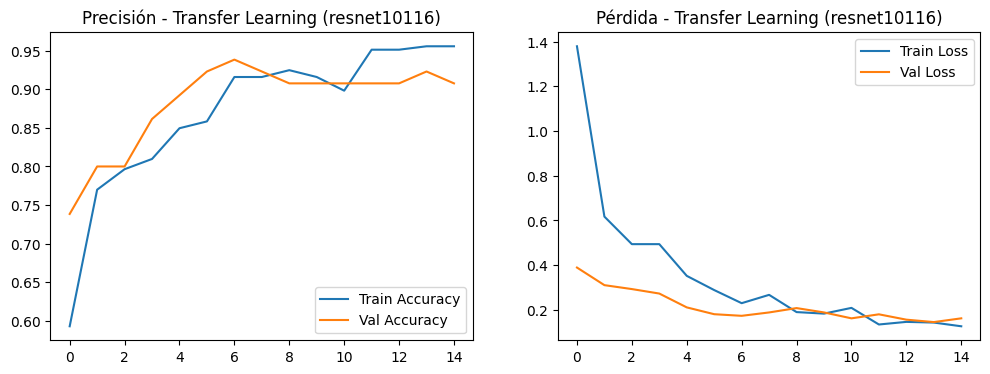

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step


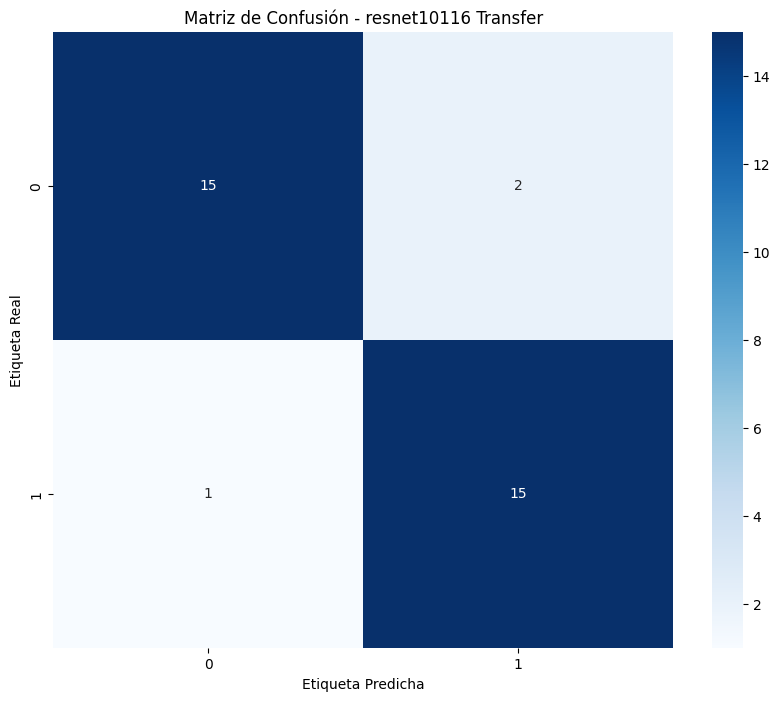

Reporte de Clasificación - Transfer Learning (resnet10116)

              precision    recall  f1-score   support

       birds       0.94      0.88      0.91        17
      drones       0.88      0.94      0.91        16

    accuracy                           0.91        33
   macro avg       0.91      0.91      0.91        33
weighted avg       0.91      0.91      0.91        33



In [27]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Graficar la historia de entrenamiento
acc_resnet101 = history_resnet101.history['accuracy']
val_acc_resnet101 = history_resnet101.history['val_accuracy']
loss_resnet101 = history_resnet101.history['loss']
val_loss_resnet101 = history_resnet101.history['val_loss']
epochs_range_resnet101 = range(len(acc_resnet101))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_resnet101, acc_resnet101, label='Train Accuracy')
plt.plot(epochs_range_resnet101, val_acc_resnet101, label='Val Accuracy')
plt.legend()
plt.title('Precisión - Transfer Learning (resnet10116)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_resnet101, loss_resnet101, label='Train Loss')
plt.plot(epochs_range_resnet101, val_loss_resnet101, label='Val Loss')
plt.legend()
plt.title('Pérdida - Transfer Learning (resnet10116)')
plt.show()

# Cargar el mejor modelo y evaluar
best_resnet101_model = load_model('best_model_resnet101.keras')
test_gen.reset()
preds_resnet101 = best_resnet101_model.predict(test_gen, verbose=1)
y_pred_resnet101 = np.argmax(preds_resnet101, axis=1)
y_true = test_gen.classes

cm_resnet101 = confusion_matrix(y_true, y_pred_resnet101)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_resnet101, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - resnet10116 Transfer')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

print("Reporte de Clasificación - Transfer Learning (resnet10116)")
print()
print(classification_report(y_true, y_pred_resnet101, target_names=labels_map, zero_division=0))

In [24]:
import tensorflow as tf

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam


# Cargar VGG16 pre-entrenado en ImageNet, sin incluir la parte superior
base_model_densenet = DenseNet201(weights='imagenet', include_top=False, input_shape=(128, 128, 3), classes=num_classes)

# Congelar todas las capas del modelo base para no reentrenarlas
for layer in base_model_densenet.layers:
    layer.trainable = False

# Construir el modelo de transfer learning
densenet = Sequential([
    base_model_densenet,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),  # Add an intermediate dense layer with ReLU
    Dropout(0.5),                    # Add dropout for regularization
    Dense(num_classes, activation='softmax')
])

# Mostrar la arquitectura del modelo
densenet.summary()

# Compilar el modelo
densenet.compile(optimizer=Adam(learning_rate= 0.5e-3),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Definir callbacks para guardar el mejor modelo, detener tempranamente y reducir la tasa de aprendizaje
callbacks_densenet = [
    ModelCheckpoint('best_model_densenet.keras', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')
]

# Entrenar el modelo de transfer learning
epochs_densenet = 15
with tf.device('/device:GPU:0'):
    history_densenet = densenet.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs_densenet,
        callbacks=callbacks_densenet
    )

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 4, 4, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │       122,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,445,058 (70.36 MB)

 Trainable params: 123,074 (480.76 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 92s 8s/step - accuracy: 0.4794 - loss: 1.1301 - val_accuracy: 0.7846 - val_loss: 0.4406 - learning_rate: 5.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 853ms/step - accuracy: 0.7401 - loss: 0.5806 - val_accuracy: 0.9077 - val_loss: 0.2886 - learning_rate: 5.0000e-04
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 709ms/step - accuracy: 0.8083 - loss: 0.3911 - val_accuracy: 0.9692 - val_loss: 0.2278 - learning_rate: 5.0000e-04
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 788ms/step - accuracy: 0.8765 - loss: 0.2815 - val_accuracy: 0.9692 - val_loss: 0.1890 - learning_rate: 5.0000e-04
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 502ms/step - accuracy: 0.9356 - loss: 0.1757 - val_accuracy: 0.9692 - val_loss: 0.1938 - learning_rate: 5.0000e-04
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 712ms/step - accuracy: 0.9291 - loss: 0.2026 - val_accuracy: 0.9538 - val_loss: 0.1534 - learning_rate: 5.0000e-04
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 667ms/step - accuracy: 0.9858 - loss: 

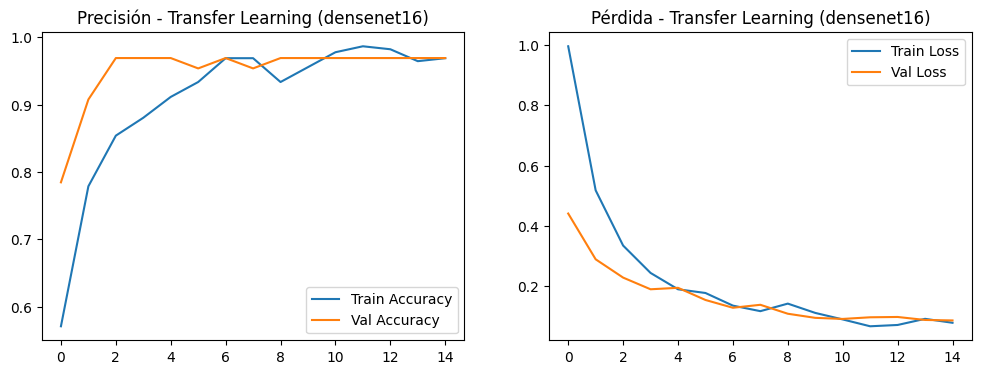

2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 18s/step


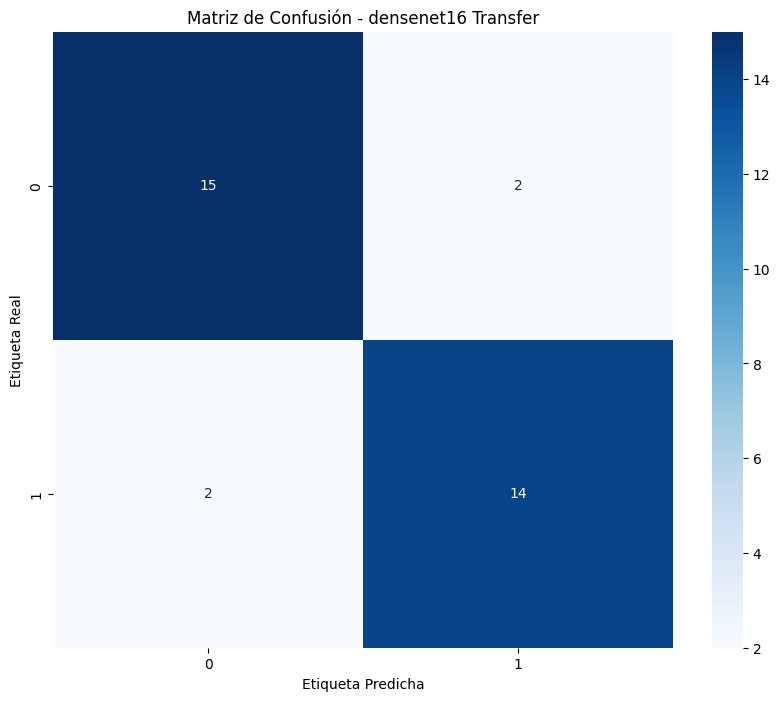

Reporte de Clasificación - Transfer Learning (densenet16)

              precision    recall  f1-score   support

       birds       0.88      0.88      0.88        17
      drones       0.88      0.88      0.88        16

    accuracy                           0.88        33
   macro avg       0.88      0.88      0.88        33
weighted avg       0.88      0.88      0.88        33



In [25]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Graficar la historia de entrenamiento
acc_densenet = history_densenet.history['accuracy']
val_acc_densenet = history_densenet.history['val_accuracy']
loss_densenet = history_densenet.history['loss']
val_loss_densenet = history_densenet.history['val_loss']
epochs_range_densenet = range(len(acc_densenet))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_densenet, acc_densenet, label='Train Accuracy')
plt.plot(epochs_range_densenet, val_acc_densenet, label='Val Accuracy')
plt.legend()
plt.title('Precisión - Transfer Learning (densenet16)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_densenet, loss_densenet, label='Train Loss')
plt.plot(epochs_range_densenet, val_loss_densenet, label='Val Loss')
plt.legend()
plt.title('Pérdida - Transfer Learning (densenet16)')
plt.show()

# Cargar el mejor modelo y evaluar
best_densenet_model = load_model('best_model_densenet.keras')
test_gen.reset()
preds_densenet = best_densenet_model.predict(test_gen, verbose=1)
y_pred_densenet = np.argmax(preds_densenet, axis=1)
y_true = test_gen.classes

cm_densenet = confusion_matrix(y_true, y_pred_densenet)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_densenet, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - densenet16 Transfer')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

print("Reporte de Clasificación - Transfer Learning (densenet16)")
print()
print(classification_report(y_true, y_pred_densenet, target_names=labels_map, zero_division=0))